#### Import Libraries

In [1]:
import numpy as np
from numpy.random import randn
from numpy.random import seed

In [2]:
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [4]:

from modAL.models import ActiveLearner

In [5]:
#Set the RNG seed for reproducibility
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)

#### Load data

In [6]:
iris = load_iris()
X_raw = iris['data']
y_raw = iris['target']

#### Data Visualization

In [7]:
#Define the PCA transformer and fit it onto the raw dataset.
pca = PCA(n_components=2, random_state=RANDOM_STATE_SEED)
transformed_iris = pca.fit_transform(X=X_raw)

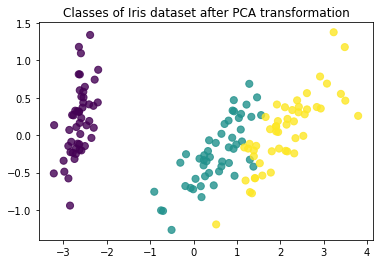

In [8]:
#Isolating the data that will need for plotting.
x_component, y_component = transformed_iris[:, 0], transformed_iris[:, 1]

#Plot the dimensionality-reduced (via PCA) dataset.
plt.figure()
plt.scatter(x=x_component, y=y_component, c=y_raw, cmap='viridis', s=50, alpha=8/10)
plt.title('Classes of Iris dataset after PCA transformation')
plt.show()

In [9]:
#Isolate the examples for the labeled dataset.
n_labeled_examples = X_raw.shape[0]
training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)

X_train = X_raw[training_indices]
y_train = y_raw[training_indices]

# Isolate the non-training examples we'll be querying.
X_test = np.delete(X_raw, training_indices, axis=0)
y_test = np.delete(y_raw, training_indices, axis=0)

#### Active Learning with pool-based sampling

In [10]:
#Specify the core estimator along with it's active learning model.
knn = KNeighborsClassifier(n_neighbors=3)
learner = ActiveLearner(estimator=knn, X_training=X_train, y_training=y_train)

In [11]:
#Isolate the data which will need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

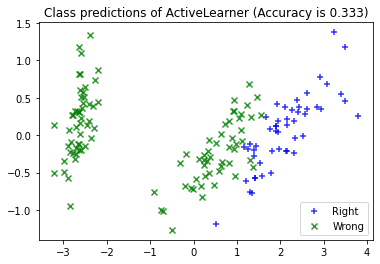

In [12]:
#Record the learner's score on the raw data.
unqueried_score = learner.score(X_raw, y_raw)

#Plot the classification results.
fig, ax = plt.subplots()
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='b', marker='+', label='Right',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='g', marker='x', label='Wrong', alpha=8/10)
ax.legend(loc='lower right')
ax.set_title("Class predictions of ActiveLearner (Accuracy is {score:.3f})".format(score=unqueried_score))
plt.show()

In [13]:
N_QUERIES = 29
performance_history = [unqueried_score]

#Allow the model to query the unlabeled dataset for the most
#Informative points according to the query strategy (uncertainty sampling).

for index in range(N_QUERIES):
    query_index, query_instance = learner.query(X_test)
    #Teach the ActiveLearner model the record it has requested.
    X, y = X_test[query_index].reshape(1, -1), y_test[query_index].reshape(1, )
    learner.teach(X=X, y=y)

    #Remove the queried instance from the unlabeled pool.
    X_test, y_test = np.delete(X_test, query_index, axis=0), np.delete(y_test, query_index)

    #Calculate and report the model's accuracy.
    model_accuracy = learner.score(X_raw, y_raw)
    print('Accuracy after the query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

    #Save the model's performance for plotting.
    performance_history.append(model_accuracy)

Accuracy after the query 1: 0.6667
Accuracy after the query 2: 0.6667
Accuracy after the query 3: 0.8800
Accuracy after the query 4: 0.8800
Accuracy after the query 5: 0.8733
Accuracy after the query 6: 0.8400
Accuracy after the query 7: 0.7400
Accuracy after the query 8: 0.7267
Accuracy after the query 9: 0.7267
Accuracy after the query 10: 0.7267
Accuracy after the query 11: 0.7267
Accuracy after the query 12: 0.7267
Accuracy after the query 13: 0.7267
Accuracy after the query 14: 0.7267
Accuracy after the query 15: 0.7200
Accuracy after the query 16: 0.8400
Accuracy after the query 17: 0.8800
Accuracy after the query 18: 0.8933
Accuracy after the query 19: 0.9267
Accuracy after the query 20: 0.9267
Accuracy after the query 21: 0.9267
Accuracy after the query 22: 0.9067
Accuracy after the query 23: 0.9400
Accuracy after the query 24: 0.9467
Accuracy after the query 25: 0.9467
Accuracy after the query 26: 0.9467
Accuracy after the query 27: 0.9467
Accuracy after the query 28: 0.9467
A

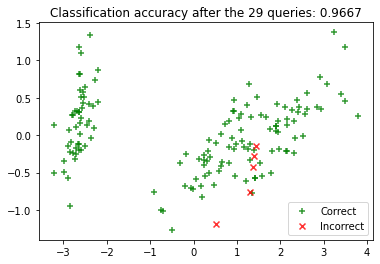

In [14]:
#Isolate the data which will need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

#Plot the updated classification results once trained the learner.
fig, ax = plt.subplots()

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)

ax.set_title('Classification accuracy after the {n} queries: {final_acc:.4f}'.format(n=N_QUERIES, final_acc=performance_history[-1]))
ax.legend(loc='lower right')

plt.show()

#### Pearson Correlation Coefficiency Testing

In [15]:
X = iris.data
y = iris.target
X_train, X_pool, y_train, y_pool = train_test_split(X, y, test_size=0.4, random_state = 4)

k_range = range(1, 30)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_pool)
    scores.append(metrics.accuracy_score(y_pool, y_pred))

In [16]:
from scipy.stats import pearsonr
seed(1)
# calculate Pearson's correlation
corr, _ = pearsonr(y_pool, y_pred)
print('Pearsons correlation coefficiency is %.4f' % corr)

Pearsons correlation coefficiency is 0.9642
